In [86]:
from collections import deque
from enum import Enum
from itertools import islice


class VirusStatesBase(Enum):
    def __init__(self, next_, rotation):
        self._next = next_
        self.rotation = rotation
    
    @property
    def next(self):
        return type(self)[self._next]
    
    def __repr__(self):
        return f'{type(self).__name__}.{self.name}'


class VirusStates(VirusStatesBase):    
    CLEAN = 'INFECTED', 1
    INFECTED = 'CLEAN', -1


class VirusGrid:
    def __init__(self, infected, states):
        self.states = states
        self.infected = dict.fromkeys(infected, states.INFECTED)
        self.directions = deque([(0, -1), (1, 0), (0, 1), (-1, 0)])
        self.pos = 0, 0

    @classmethod
    def from_lines(cls, lines, states=VirusStates):
        # assumption: grid is square
        infected = set()
        halfsize = None
        for row, line in enumerate(lines):
            line = line.strip()
            if halfsize is None:
                halfsize = len(line) // 2
            y = row - halfsize
            infected.update(
                (x, y) for x, f in enumerate(line, -halfsize)
                if f == '#')
        return cls(infected, states)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        state = self.infected.get(self.pos, self.states.CLEAN)
        self.directions.rotate(state.rotation)
        next_state = state.next
        if next_state is self.states.CLEAN:
            del self.infected[self.pos]
        else:
            self.infected[self.pos] = next_state
        dx, dy = self.directions[0]
        self.pos = self.pos[0] + dx, self.pos[1] + dy
        return state.next


class EvolvedVirusStates(VirusStatesBase):
    # value is next state and directions rotation
    CLEAN = 'WEAKENED', 1
    WEAKENED = 'INFECTED', 0
    INFECTED = 'FLAGGED', -1
    FLAGGED = 'CLEAN', 2

In [88]:
test_grid_1 = VirusGrid.from_lines('''\
..#
#..
...'''.splitlines())
assert sum(state is VirusStates.INFECTED for state in islice(test_grid_1, 10000)) == 5587

In [90]:
with open('inputs/day22.txt') as day22:
    grid_1 = VirusGrid.from_lines(day22)

print('Part 1:', sum(state is VirusStates.INFECTED for state in islice(grid_1, 10000)))

Part 1: 5411


In [93]:
test_grid_2 = VirusGrid.from_lines('''\
..#
#..
...'''.splitlines(), EvolvedVirusStates)
assert sum(state is EvolvedVirusStates.INFECTED for state in islice(test_grid_2, 10000000)) == 2511944

In [94]:
with open('inputs/day22.txt') as day22:
    grid_2 = VirusGrid.from_lines(day22, EvolvedVirusStates)

print('Part 2:', sum(state is EvolvedVirusStates.INFECTED for state in islice(grid_2, 10000000)))

Part 2: 2511416


In [95]:
def bounds(infected):
    x_range = min(x for x, y in infected), max(x for x, y in infected)
    y_range = min(y for x, y in infected), max(y for x, y in infected)
    return x_range + y_range

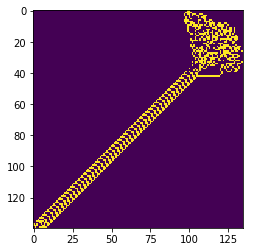

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

bbox = bounds(grid_1.infected)
image = np.array([[(x, y) in grid_1.infected for x in range(*bbox[:2])] for y in range(*bbox[2:])])
plt.imshow(image)

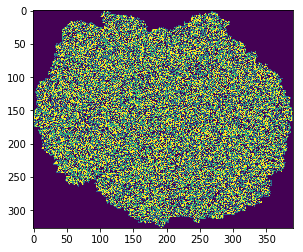

In [98]:
bbox = bounds(grid_2.infected)

grades = {
    EvolvedVirusStates.CLEAN: 0,
    EvolvedVirusStates.WEAKENED: 85,
    EvolvedVirusStates.INFECTED: 170,
    EvolvedVirusStates.FLAGGED: 255,
}

image = np.array([[grades[grid_2.infected.get((x, y), EvolvedVirusStates.CLEAN)] for x in range(*bbox[:2])] for y in range(*bbox[2:])])

plt.imshow(image)